### Importação das Bibliotecas

In [1]:
# Importação das bibliotecas
import random
import numpy as np
import matplotlib.pyplot as plt

### Modelagem de Dados

In [19]:
# Funcionários
funcionarios = [
    {"id": 1, "nome": "Ana", "preferencias_folga": ["domingo"]},
    {"id": 2, "nome": "Bruno", "preferencias_folga": ["sábado"]},
    {"id": 3, "nome": "Carla", "preferencias_folga": ["segunda"]},
    {"id": 4, "nome": "Diego", "preferencias_folga": ["terça"]},
    {"id": 5, "nome": "Elisa", "preferencias_folga": ["quarta"]},
    {"id": 6, "nome": "Felipe", "preferencias_folga": ["sexta"]},
]

# Dias e turnos
semana = ["segunda", "terça", "quarta", "quinta", "sexta", "sábado", "domingo"]
turnos = ["manha", "tarde", "noite"]

### Restrições

In [9]:
CARGA_MAX_SEMANAL = 6  # máximo de turnos por semana por funcionário
FOLGAS_OBRIGATORIAS = 1  # mínimo de folgas por semana
COBERTURA_MINIMA = 2  # mínimo de funcionários por turno

def checar_restricoes(escala, funcionarios, semana, turnos):
    violacoes = []
    # 1. Carga horária máxima e folgas obrigatórias
    for f in funcionarios:
        total_turnos = sum(escala[f["id"]][dia][turno] for dia in semana for turno in turnos)
        folgas = sum(all(escala[f["id"]][dia][t] == 0 for t in turnos) for dia in semana)
        if total_turnos > CARGA_MAX_SEMANAL:
            violacoes.append(f"{f['nome']} excedeu carga máxima semanal.")
        if folgas < FOLGAS_OBRIGATORIAS:
            violacoes.append(f"{f['nome']} não tem folgas suficientes.")
    # 2. Cobertura mínima por turno
    for dia in semana:
        for turno in turnos:
            trabalhando = sum(escala[f["id"]][dia][turno] for f in funcionarios)
            if trabalhando < COBERTURA_MINIMA:
                violacoes.append(f"Cobertura insuficiente em {dia} {turno}.")
    return violacoes

### Implementação do Algoritimo Genético

Número de violações encontradas: 3
 - Ana excedeu carga máxima semanal.
 - Bruno excedeu carga máxima semanal.
 - Diego excedeu carga máxima semanal.


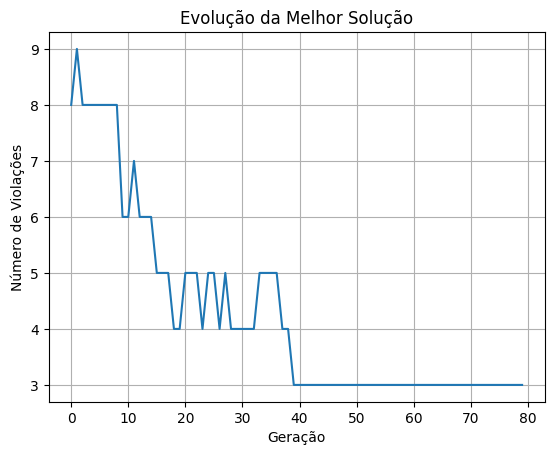

In [55]:
# Parâmetros do algoritmo genético
USAR_ELITISMO = False  # Se True, mantém o melhor indivíduo de cada geração
POP_SIZE = 20
N_GERACOES = 80
TAXA_MUTACAO = 0.2

# Geração de individuo aleatório (escala de trabalho)
def gerar_individuo(funcionarios, semana, turnos):
    escala = {f["id"]: {dia: {turno: 0 for turno in turnos} for dia in semana} for f in funcionarios}
    for f in funcionarios:
        dias_trabalhados = random.sample(semana, CARGA_MAX_SEMANAL)
        for dia in dias_trabalhados:
            turno = random.choice(turnos)
            escala[f["id"]][dia][turno] = 1
    return escala

# Avaliação do indivíduo (número de violações)
def avaliar_individuo(individuo, funcionarios, semana, turnos):
    violacoes = checar_restricoes(individuo, funcionarios, semana, turnos)
    return len(violacoes)

# Seleção de pais (torneio)
def selecionar_pais(populacao, funcionarios, semana, turnos):
    pais = []
    for _ in range(2):
        torneio = random.sample(populacao, 3)
        melhor = min(torneio, key=lambda ind: avaliar_individuo(ind, funcionarios, semana, turnos))
        pais.append(melhor)
    return pais

# Cruzamento de pais - Versão refatorada
def cruzar_pais(pai1, pai2):
    """
    Gera um filho combinando características dos dois pais.
    Cada posição da escala é herdada aleatoriamente de um dos pais.
    """
    filho = {}
    
    for funcionario_id in pai1.keys():
        filho[funcionario_id] = {}
        
        for dia in pai1[funcionario_id].keys():
            filho[funcionario_id][dia] = {}
            
            for turno in pai1[funcionario_id][dia].keys():
                # Escolha aleatória entre os pais
                pai_escolhido = pai1 if random.random() < 0.5 else pai2
                filho[funcionario_id][dia][turno] = pai_escolhido[funcionario_id][dia][turno]
    
    return filho

# Mutação do indivíduo
def mutar_individuo(individuo, funcionarios, semana, turnos):
    for f in funcionarios:
        if random.random() < TAXA_MUTACAO:
            dia = random.choice(semana)
            turno = random.choice(turnos)
            if individuo[f["id"]][dia][turno] == 1:
                individuo[f["id"]][dia][turno] = 0  # Remove o turno
            else:
                individuo[f["id"]][dia][turno] = 1  # Adiciona o turno
    return individuo

# Inicialização da população
populacao = [gerar_individuo(funcionarios, semana, turnos) for _ in range(POP_SIZE)]

# Evolução da população
melhores_geracoes = []
for geracao in range(N_GERACOES):
    nova_populacao = []
    
    # Avaliar e ordenar a população
    populacao_ordenada = sorted(populacao, key=lambda ind: avaliar_individuo(ind, funcionarios, semana, turnos), reverse=False)
    
    # Manter o melhor indivíduo se elitismo for usado
    if USAR_ELITISMO:
        nova_populacao.append(populacao_ordenada[0])
    
    # Seleção e cruzamento
    while len(nova_populacao) < POP_SIZE:
        pai1, pai2 = selecionar_pais(populacao_ordenada, funcionarios, semana, turnos)             
        filho = cruzar_pais(pai1, pai2)        
        filho = mutar_individuo(filho, funcionarios, semana, turnos)
        nova_populacao.append(filho)
    
    populacao = nova_populacao
    melhores_geracoes.append(populacao_ordenada[0])

# Avaliação da melhor escala encontrada
melhor_individuo = min(melhores_geracoes, key=lambda ind: avaliar_individuo(ind, funcionarios, semana, turnos))
# print("Melhor escala encontrada:")
# for f in funcionarios:
#     print(f"{f['nome']}: ", end="")
#     for dia in semana:
#         for turno in turnos:
#             if melhor_individuo[f["id"]][dia][turno] == 1:
#                 print(f"{dia} {turno}, ", end="")
#     print()

# Verificação das restrições na melhor escala
violacoes = checar_restricoes(melhor_individuo, funcionarios, semana, turnos)
if violacoes:
    print(f"Número de violações encontradas: {len(violacoes)}")
    for v in violacoes:
        print(f" - {v}")
else:
    print("✅ Nenhuma violação encontrada! Escala válida.")

# Plotando a evolução da melhor solução
melhores_aval = [avaliar_individuo(ind, funcionarios, semana, turnos) for ind in melhores_geracoes]
plt.plot(melhores_aval)
plt.title("Evolução da Melhor Solução")
plt.xlabel("Geração")
plt.ylabel("Número de Violações")
plt.grid()
plt.show()

In [24]:
individuo = gerar_individuo(funcionarios, semana, turnos)
individuo

{1: {'segunda': {'manha': 0, 'tarde': 0, 'noite': 1},
  'terça': {'manha': 0, 'tarde': 0, 'noite': 0},
  'quarta': {'manha': 1, 'tarde': 0, 'noite': 0},
  'quinta': {'manha': 0, 'tarde': 0, 'noite': 1},
  'sexta': {'manha': 1, 'tarde': 0, 'noite': 0},
  'sábado': {'manha': 0, 'tarde': 1, 'noite': 0},
  'domingo': {'manha': 1, 'tarde': 0, 'noite': 0}},
 2: {'segunda': {'manha': 1, 'tarde': 0, 'noite': 0},
  'terça': {'manha': 1, 'tarde': 0, 'noite': 0},
  'quarta': {'manha': 0, 'tarde': 1, 'noite': 0},
  'quinta': {'manha': 1, 'tarde': 0, 'noite': 0},
  'sexta': {'manha': 0, 'tarde': 1, 'noite': 0},
  'sábado': {'manha': 0, 'tarde': 0, 'noite': 1},
  'domingo': {'manha': 0, 'tarde': 0, 'noite': 0}},
 3: {'segunda': {'manha': 0, 'tarde': 1, 'noite': 0},
  'terça': {'manha': 0, 'tarde': 0, 'noite': 1},
  'quarta': {'manha': 0, 'tarde': 1, 'noite': 0},
  'quinta': {'manha': 0, 'tarde': 0, 'noite': 1},
  'sexta': {'manha': 0, 'tarde': 0, 'noite': 0},
  'sábado': {'manha': 0, 'tarde': 1, 'no

### Teste das Restrições com Dados Simples

In [13]:
# Exemplo 1: Escala que VIOLA várias restrições
escala_com_violacoes = {
    f["id"]: {dia: {turno: 0 for turno in turnos} for dia in semana} for f in funcionarios
}

len(escala_com_violacoes)

4

In [21]:
# Criando dados de teste para validar a função checar_restricoes

# Exemplo 1: Escala que VIOLA várias restrições
escala_com_violacoes = {
    f["id"]: {dia: {turno: 0 for turno in turnos} for dia in semana} for f in funcionarios
}

# Ana trabalha TODOS os turnos de segunda a quinta (violação de carga máxima)
for dia in ["segunda", "terça", "quarta", "quinta"]:
    for turno in turnos:
        escala_com_violacoes[1][dia][turno] = 1

# Bruno trabalha apenas 1 turno (violação de cobertura mínima em vários turnos)
escala_com_violacoes[2]["sexta"]["manha"] = 1

# Carla, Diego e Elisa não trabalham (violação de cobertura mínima)

print("=== TESTE 1: Escala com VIOLAÇÕES ===")
violacoes = checar_restricoes(escala_com_violacoes, funcionarios, semana, turnos)
print(f"Número de violações encontradas: {len(violacoes)}")
# for v in violacoes:
#     print(f" - {v}")

print("\n" + "="*50 + "\n")

# Exemplo 2: Escala VÁLIDA (sem violações)
escala_valida = {
    f["id"]: {dia: {turno: 0 for turno in turnos} for dia in semana} for f in funcionarios
}

# Distribuir turnos de forma equilibrada (cada funcionário trabalha 6 turnos)
turnos_por_funcionario = [
    # Ana: trabalha de segunda a sábado de manhã, folga domingo (sua preferência)
    [(1, "segunda", "manha"), (1, "terça", "manha"), (1, "quarta", "manha"), 
     (1, "quinta", "manha"), (1, "sexta", "manha"), (1, "sábado", "manha")],
    
    # Bruno: trabalha de segunda a sexta de tarde, folga sábado (sua preferência) e domingo
    [(2, "segunda", "tarde"), (2, "terça", "tarde"), (2, "quarta", "tarde"), 
     (2, "quinta", "tarde"), (2, "sexta", "tarde"), (2, "domingo", "tarde")],
    
    # Carla: trabalha de terça a domingo de noite, folga segunda (sua preferência)
    [(3, "terça", "noite"), (3, "quarta", "noite"), (3, "quinta", "noite"), 
     (3, "sexta", "noite"), (3, "sábado", "noite"), (3, "domingo", "noite")],
    
    # Diego: trabalha alguns turnos para garantir cobertura
    [(4, "segunda", "noite"), (4, "quarta", "tarde"), (4, "quinta", "tarde"), 
     (4, "sexta", "tarde"), (4, "sábado", "tarde"), (4, "domingo", "manha")],
    
    # Elisa: trabalha alguns turnos para garantir cobertura, folga quarta (sua preferência)
    [(5, "segunda", "tarde"), (5, "terça", "tarde"), (5, "quinta", "noite"), 
     (5, "sexta", "noite"), (5, "sábado", "noite"), (5, "domingo", "noite")],

    # Felipe: trabalha alguns turnos para garantir cobertura, folga sexta (sua preferência)
    [(6, "segunda", "manha"), (6, "terça", "manha"), (6, "quarta", "manha"),
     (6, "quinta", "manha"), (6, "sábado", "manha"), (6, "domingo", "manha")]
]

# Aplicar os turnos na escala
for funcionario_turnos in turnos_por_funcionario:
    for func_id, dia, turno in funcionario_turnos:
        escala_valida[func_id][dia][turno] = 1

print("=== TESTE 2: Escala VÁLIDA ===")
violacoes = checar_restricoes(escala_valida, funcionarios, semana, turnos)
if violacoes:
    print(f"Número de violações encontradas: {len(violacoes)}")
    for v in violacoes:
        print(f" - {v}")
else:
    print("✅ Nenhuma violação encontrada! Escala válida.")

# Verificar algumas estatísticas da escala válida
print("\n📊 Estatísticas da escala válida:")
for f in funcionarios:
    total_turnos = sum(escala_valida[f["id"]][dia][turno] for dia in semana for turno in turnos)
    folgas = sum(all(escala_valida[f["id"]][dia][t] == 0 for t in turnos) for dia in semana)
    print(f" - {f['nome']}: {total_turnos} turnos, {folgas} folgas")

=== TESTE 1: Escala com VIOLAÇÕES ===
Número de violações encontradas: 22


=== TESTE 2: Escala VÁLIDA ===
Número de violações encontradas: 6
 - Cobertura insuficiente em segunda noite.
 - Cobertura insuficiente em terça noite.
 - Cobertura insuficiente em quarta noite.
 - Cobertura insuficiente em sexta manha.
 - Cobertura insuficiente em sábado tarde.
 - Cobertura insuficiente em domingo tarde.

📊 Estatísticas da escala válida:
 - Ana: 6 turnos, 1 folgas
 - Bruno: 6 turnos, 1 folgas
 - Carla: 6 turnos, 1 folgas
 - Diego: 6 turnos, 1 folgas
 - Elisa: 6 turnos, 1 folgas
 - Felipe: 6 turnos, 1 folgas


### Versões Melhoradas: Cruzamento e Mutação Inteligentes

In [25]:
# VERSÃO MELHORADA: Cruzamento que respeita carga máxima
def cruzar_pais_inteligente(pai1, pai2, funcionarios, semana, turnos):
    filho = {f["id"]: {dia: {turno: 0 for turno in turnos} for dia in semana} for f in funcionarios}
    
    for f in funcionarios:
        # Coletar todos os turnos dos pais para este funcionário
        turnos_pai1 = [(dia, turno) for dia in semana for turno in turnos 
                       if pai1[f["id"]][dia][turno] == 1]
        turnos_pai2 = [(dia, turno) for dia in semana for turno in turnos 
                       if pai2[f["id"]][dia][turno] == 1]
        
        # Misturar turnos dos dois pais
        turnos_candidatos = turnos_pai1 + turnos_pai2
        random.shuffle(turnos_candidatos)
        
        # Selecionar até a carga máxima, evitando duplicatas
        turnos_selecionados = []
        for dia, turno in turnos_candidatos:
            if len(turnos_selecionados) >= CARGA_MAX_SEMANAL:
                break
            if (dia, turno) not in turnos_selecionados:
                turnos_selecionados.append((dia, turno))
        
        # Se não atingiu a carga máxima, preencher aleatoriamente
        if len(turnos_selecionados) < CARGA_MAX_SEMANAL:
            todos_turnos = [(dia, turno) for dia in semana for turno in turnos]
            turnos_livres = [t for t in todos_turnos if t not in turnos_selecionados]
            random.shuffle(turnos_livres)
            faltam = CARGA_MAX_SEMANAL - len(turnos_selecionados)
            turnos_selecionados.extend(turnos_livres[:faltam])
        
        # Aplicar na escala do filho
        for dia, turno in turnos_selecionados:
            filho[f["id"]][dia][turno] = 1
    
    return filho

# VERSÃO MELHORADA: Mutação que preserva carga máxima
def mutar_individuo_inteligente(individuo, funcionarios, semana, turnos):
    novo_individuo = {f["id"]: {dia: {turno: individuo[f["id"]][dia][turno] 
                               for turno in turnos} for dia in semana} for f in funcionarios}
    
    for f in funcionarios:
        if random.random() < TAXA_MUTACAO:
            # Obter turnos atuais do funcionário
            turnos_ocupados = [(dia, turno) for dia in semana for turno in turnos 
                              if novo_individuo[f["id"]][dia][turno] == 1]
            turnos_livres = [(dia, turno) for dia in semana for turno in turnos 
                            if novo_individuo[f["id"]][dia][turno] == 0]
            
            # Estratégias de mutação inteligente
            if len(turnos_ocupados) > 0 and len(turnos_livres) > 0:
                # Trocar um turno ocupado por um livre (mantém a carga)
                dia_remove, turno_remove = random.choice(turnos_ocupados)
                dia_adiciona, turno_adiciona = random.choice(turnos_livres)
                
                novo_individuo[f["id"]][dia_remove][turno_remove] = 0
                novo_individuo[f["id"]][dia_adiciona][turno_adiciona] = 1
            
            elif len(turnos_ocupados) > CARGA_MAX_SEMANAL:
                # Se está sobrecarregado, remover turnos
                dia_remove, turno_remove = random.choice(turnos_ocupados)
                novo_individuo[f["id"]][dia_remove][turno_remove] = 0
                
            elif len(turnos_ocupados) < CARGA_MAX_SEMANAL and len(turnos_livres) > 0:
                # Se está subcarregado, adicionar turnos
                dia_adiciona, turno_adiciona = random.choice(turnos_livres)
                novo_individuo[f["id"]][dia_adiciona][turno_adiciona] = 1
    
    return novo_individuo

# FUNÇÃO PARA REPARAR INDIVÍDUOS (corrigir violações básicas)
def reparar_individuo(individuo, funcionarios, semana, turnos):
    reparado = {f["id"]: {dia: {turno: individuo[f["id"]][dia][turno] 
                         for turno in turnos} for dia in semana} for f in funcionarios}
    
    for f in funcionarios:
        # Contar turnos atuais
        turnos_ocupados = [(dia, turno) for dia in semana for turno in turnos 
                          if reparado[f["id"]][dia][turno] == 1]
        
        # Se excede a carga máxima, remover turnos aleatórios
        if len(turnos_ocupados) > CARGA_MAX_SEMANAL:
            excesso = len(turnos_ocupados) - CARGA_MAX_SEMANAL
            turnos_para_remover = random.sample(turnos_ocupados, excesso)
            for dia, turno in turnos_para_remover:
                reparado[f["id"]][dia][turno] = 0
        
        # Se está abaixo da carga máxima, adicionar turnos
        elif len(turnos_ocupados) < CARGA_MAX_SEMANAL:
            turnos_livres = [(dia, turno) for dia in semana for turno in turnos 
                            if reparado[f["id"]][dia][turno] == 0]
            if turnos_livres:
                faltam = min(CARGA_MAX_SEMANAL - len(turnos_ocupados), len(turnos_livres))
                turnos_para_adicionar = random.sample(turnos_livres, faltam)
                for dia, turno in turnos_para_adicionar:
                    reparado[f["id"]][dia][turno] = 1
    
    return reparado

print("✅ Funções inteligentes implementadas:")
print("   • cruzar_pais_inteligente(): Respeita carga máxima")
print("   • mutar_individuo_inteligente(): Preserva restrições")
print("   • reparar_individuo(): Corrige violações básicas")

✅ Funções inteligentes implementadas:
   • cruzar_pais_inteligente(): Respeita carga máxima
   • mutar_individuo_inteligente(): Preserva restrições
   • reparar_individuo(): Corrige violações básicas


### Teste Comparativo: Métodos Normais vs Inteligentes

In [28]:
# Teste comparativo entre métodos normais e inteligentes
import time

def testar_metodos(num_testes=100):
    violacoes_normais = []
    violacoes_inteligentes = []
    
    print("🧪 Testando métodos de cruzamento e mutação...")
    print(f"Realizando {num_testes} testes para cada método\n")
    
    for i in range(num_testes):
        # Gerar dois pais aleatórios
        pai1 = gerar_individuo(funcionarios, semana, turnos)
        pai2 = gerar_individuo(funcionarios, semana, turnos)
        
        # MÉTODO NORMAL
        filho_normal = cruzar_pais(pai1, pai2)
        filho_normal = mutar_individuo(filho_normal, funcionarios, semana, turnos)
        violacoes_normal = avaliar_individuo(filho_normal, funcionarios, semana, turnos)
        violacoes_normais.append(violacoes_normal)
        
        # MÉTODO INTELIGENTE
        filho_inteligente = cruzar_pais_inteligente(pai1, pai2, funcionarios, semana, turnos)
        filho_inteligente = mutar_individuo_inteligente(filho_inteligente, funcionarios, semana, turnos)
        violacoes_inteligente = avaliar_individuo(filho_inteligente, funcionarios, semana, turnos)
        violacoes_inteligentes.append(violacoes_inteligente)
    
    # Estatísticas
    print("📊 RESULTADOS DO TESTE COMPARATIVO:")
    print(f"\n🔴 MÉTODO NORMAL:")
    print(f"   • Média de violações: {np.mean(violacoes_normais):.2f}")
    print(f"   • Soluções sem violação: {sum(1 for v in violacoes_normais if v == 0)}/{num_testes} ({sum(1 for v in violacoes_normais if v == 0)/num_testes*100:.1f}%)")
    print(f"   • Máximo de violações: {max(violacoes_normais)}")
    
    print(f"\n🟢 MÉTODO INTELIGENTE:")
    print(f"   • Média de violações: {np.mean(violacoes_inteligentes):.2f}")
    print(f"   • Soluções sem violação: {sum(1 for v in violacoes_inteligentes if v == 0)}/{num_testes} ({sum(1 for v in violacoes_inteligentes if v == 0)/num_testes*100:.1f}%)")
    print(f"   • Máximo de violações: {max(violacoes_inteligentes)}")
    
    melhoria = (np.mean(violacoes_normais) - np.mean(violacoes_inteligentes)) / np.mean(violacoes_normais) * 100
    print(f"\n💡 MELHORIA: {melhoria:.1f}% menos violações com método inteligente")
    
    return violacoes_normais, violacoes_inteligentes

# Executar teste
violacoes_normais, violacoes_inteligentes = testar_metodos(50)

🧪 Testando métodos de cruzamento e mutação...
Realizando 50 testes para cada método

📊 RESULTADOS DO TESTE COMPARATIVO:

🔴 MÉTODO NORMAL:
   • Média de violações: 11.96
   • Soluções sem violação: 0/50 (0.0%)
   • Máximo de violações: 16

🟢 MÉTODO INTELIGENTE:
   • Média de violações: 9.64
   • Soluções sem violação: 0/50 (0.0%)
   • Máximo de violações: 14

💡 MELHORIA: 19.4% menos violações com método inteligente


### Uso Prático da Função `reparar_individuo`

In [29]:
# A função reparar_individuo pode ser usada em várias situações:

print("🔧 DEMONSTRAÇÃO DO USO DA FUNÇÃO reparar_individuo:\n")

# 1. REPARAR APÓS CRUZAMENTO/MUTAÇÃO NORMAIS
print("1️⃣ Reparar após operações normais:")
pai1 = gerar_individuo(funcionarios, semana, turnos)
pai2 = gerar_individuo(funcionarios, semana, turnos)

# Cruzamento e mutação normais (podem gerar violações)
filho_com_problemas = cruzar_pais(pai1, pai2)
filho_com_problemas = mutar_individuo(filho_com_problemas, funcionarios, semana, turnos)

print(f"   Violações ANTES do reparo: {avaliar_individuo(filho_com_problemas, funcionarios, semana, turnos)}")

# Aplicar reparo
filho_reparado = reparar_individuo(filho_com_problemas, funcionarios, semana, turnos)
print(f"   Violações APÓS o reparo: {avaliar_individuo(filho_reparado, funcionarios, semana, turnos)}")

print("\n" + "-"*60 + "\n")

# 2. INTEGRAÇÃO NO ALGORITMO GENÉTICO
print("2️⃣ Versão do algoritmo genético COM reparo automático:")

def algoritmo_genetico_com_reparo(num_geracoes=10, usar_reparo=True):
    # População inicial
    populacao = [gerar_individuo(funcionarios, semana, turnos) for _ in range(POP_SIZE)]
    
    # Se usar reparo, aplicar na população inicial
    if usar_reparo:
        populacao = [reparar_individuo(ind, funcionarios, semana, turnos) for ind in populacao]
    
    evolucao_fitness = []
    
    for geracao in range(num_geracoes):
        # Avaliar população
        fitness_pop = [avaliar_individuo(ind, funcionarios, semana, turnos) for ind in populacao]
        melhor_fitness = min(fitness_pop)
        evolucao_fitness.append(melhor_fitness)
        
        # Nova geração
        nova_populacao = []
        for _ in range(POP_SIZE):
            pais = selecionar_pais(populacao, funcionarios, semana, turnos)
            filho = cruzar_pais(pais[0], pais[1])
            filho = mutar_individuo(filho, funcionarios, semana, turnos)
            
            # APLICAR REPARO SE HABILITADO
            if usar_reparo:
                filho = reparar_individuo(filho, funcionarios, semana, turnos)
            
            nova_populacao.append(filho)
        
        populacao = nova_populacao
    
    return evolucao_fitness, populacao

# Teste comparativo: COM e SEM reparo
print("   Testando algoritmo SEM reparo:")
evolucao_sem_reparo, _ = algoritmo_genetico_com_reparo(10, usar_reparo=False)
print(f"   Melhor fitness final: {min(evolucao_sem_reparo)}")

print("   Testando algoritmo COM reparo:")
evolucao_com_reparo, pop_final = algoritmo_genetico_com_reparo(10, usar_reparo=True)
print(f"   Melhor fitness final: {min(evolucao_com_reparo)}")

print("\n" + "-"*60 + "\n")

# 3. REPARO PÓS-PROCESSAMENTO
print("3️⃣ Reparo como pós-processamento:")
print("   Aplicar reparo na melhor solução encontrada...")

melhor_individuo = min(pop_final, key=lambda ind: avaliar_individuo(ind, funcionarios, semana, turnos))
melhor_reparado = reparar_individuo(melhor_individuo, funcionarios, semana, turnos)

print(f"   Violações da melhor solução: {avaliar_individuo(melhor_individuo, funcionarios, semana, turnos)}")
print(f"   Violações após reparo final: {avaliar_individuo(melhor_reparado, funcionarios, semana, turnos)}")

print("\n🎯 CONCLUSÃO:")
print("   A função reparar_individuo pode ser usada:")
print("   • Durante o algoritmo genético (a cada geração)")
print("   • Após cruzamento/mutação (correção imediata)")
print("   • Como pós-processamento (polir solução final)")
print("   • Na população inicial (garantir viabilidade)")

🔧 DEMONSTRAÇÃO DO USO DA FUNÇÃO reparar_individuo:

1️⃣ Reparar após operações normais:
   Violações ANTES do reparo: 11
   Violações APÓS o reparo: 7

------------------------------------------------------------

2️⃣ Versão do algoritmo genético COM reparo automático:
   Testando algoritmo SEM reparo:
   Melhor fitness final: 6
   Testando algoritmo COM reparo:
   Melhor fitness final: 7

------------------------------------------------------------

3️⃣ Reparo como pós-processamento:
   Aplicar reparo na melhor solução encontrada...
   Violações da melhor solução: 6
   Violações após reparo final: 6

🎯 CONCLUSÃO:
   A função reparar_individuo pode ser usada:
   • Durante o algoritmo genético (a cada geração)
   • Após cruzamento/mutação (correção imediata)
   • Como pós-processamento (polir solução final)
   • Na população inicial (garantir viabilidade)
   Melhor fitness final: 7

------------------------------------------------------------

3️⃣ Reparo como pós-processamento:
   Aplic